References:

- http://www.verivital.com/research/tran2019fm.pdf

In [2]:
using Revise
using LazySets, Plots
using LazySets: center
using LinearAlgebra

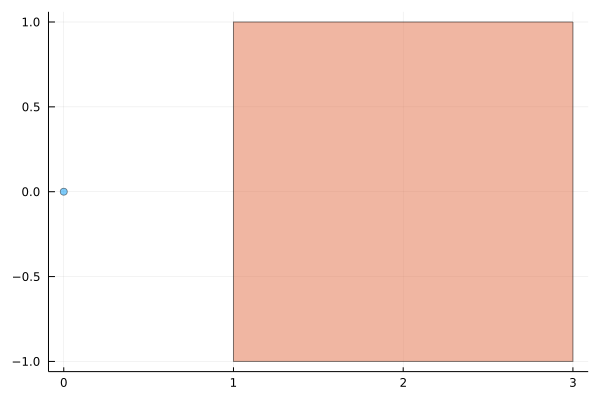

In [8]:
c = zeros(2)
V = Matrix(1.0I, 2, 2)
P = BallInf([2.0, 0.0], 1.0)
Θ = Star(c, V, P)

plot(ZeroSet(2))
plot!(Θ)

In [ ]:
# input star
#Θbox = box_approximation(Θ)

In [46]:
function reachRELU(Θ::ST) where {ST<:LazySets.STAR}

    n = LazySets.dim(Θ)
    Θbox = box_approximation(Θ)
    
    # processing list
    out = Vector{Vector{ST}}(undef, n+1)
    out[1] = [Θ]

    for k in 1:n  # loop over directions

        # get lower bound on the current direction
        lb = low(Θbox, k)

        # check if the star is included in the current positive orthant
        #lb ≥ 0 && continue
        if lb ≥ 0
           out[k+1] = out[k] # identity 
        end

        ub = high(Θbox, k)
        out[k+1] = stepRELU(out[k], k, lb, ub)
    end

    return out[end]
end

function _relu_projection_matrix(k, n; N=Float64)
    M = Matrix(one(N)*I, n, n)
    M[:, k] .= zero(N)
    return M
end

# could also return a SEV
function _relu_projection_halfspace(k, n; N=Float64)
    a = zeros(N, n)
    a[k] = -one(N)
    b = zero(N)
    return HalfSpace(a, b)
end

function _relu_projection_halfspace_neg(k, n; N=Float64)
    a = zeros(N, n)
    a[k] = one(N)
    b = zero(N)
    return HalfSpace(a, b)
end

function stepRELU(Θ::ST, k, lb, ub) where {ST<:LazySets.STAR}
    n = dim(Θ)
    
    # no-op: all positive
    if lb ≥ 0
        return [Θ]
    end

    # all negative
    M = _relu_projection_matrix(k, n)
    if ub ≤ 0
        Θnew = linear_map_lazy(M, Θ)
        return [Θnew] 
    end

    # general case
    H = _relu_projection_halfspace(k, n) # x[k] ≥ 0
    Θnew_pos = intersection(Θ, H)

    Hneg = _relu_projection_halfspace_neg(k, n) # x[k] < 0
    Θnew_neg = intersection(Θ, Hneg)
    M = _relu_projection_matrix(k, n)
    Θnew_neg = linear_map_lazy(M, Θnew_neg)
    return [Θnew_pos, Θnew_neg]
end
    
function stepRELU(Θ::Vector{ST}, k, lb, ub) where {ST<:LazySets.STAR}
    out = Vector{ST}()
    for Θi in Θ
        append!(out, stepRELU(Θi, k, lb, ub))
    end
    return out
end

stepRELU (generic function with 3 methods)

In [47]:
reachRELU(Θ)

LoadError: MethodError: [0mCannot `convert` an object of type 
[0m  AffineMap{Float64{},[92mHPolyhedron{Float64, Vector{Float64}}[39m,Float64{},Array{Float64{},2},Array{Float64{},1}}[0m to an object of type 
[0m  AffineMap{Float64{},[91mBallInf{Float64, Vector{Float64}}[39m,Float64{},Array{Float64{},2},Array{Float64{},1}}
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::T[39m) where T at essentials.jl:205

In [30]:
Θ

AffineMap{Float64, BallInf{Float64, Vector{Float64}}, Float64, Matrix{Float64}, Vector{Float64}}([1.0 0.0; 0.0 1.0], BallInf{Float64, Vector{Float64}}([2.0, 0.0], 1.0), [0.0, 0.0])

In [37]:
M = _relu_projection_matrix(2, 2)

@which linear_map(M, Θ)

linear_map(M::AbstractMatrix{T} where T, am::AbstractAffineMap) in LazySets at /home/mforets/.julia/dev/LazySets/src/Interfaces/AbstractAffineMap.jl:302

In [38]:
?AffineMap

search: AffineMap affine_map AbstractAffineMap



```
AffineMap{N, S<:LazySet{N}, NM, MAT<:AbstractMatrix{NM},
          VN<:AbstractVector{NM}} <: AbstractAffineMap{N, S}
```

Type that represents an affine transformation $M⋅X ⊕ v$ of a set $X$, that is the set

$$
Y = \{ y ∈ \mathbb{R}^n : y = Mx + v,\qquad x ∈ X \}.
$$

If $X$ is $n$-dimensional then $M$ should be an $m × n$ matrix and  ``v ∈ \mathbb{R}^m`.

### Fields

  * `M` – matrix
  * `X` – set
  * `v` – translation vector

The fields' getter functions are `matrix`, `set` and `vector` respectively.

### Notes

An affine map is the composition of a linear map and a translation. This type is parametric in the coefficients of the linear map, `NM`, which may be different from the numeric type of the wrapped set, `N`. However, the numeric type of the translation vector should be `NM`.

### Examples

For the examples we create a $3×2$ matrix, a two-dimensional unit square, and a three-dimensional vector. Then we combine them in an `AffineMap`.

```jldoctest constructors
julia> A = [1 2; 1 3; 1 4]; X = BallInf([0, 0], 1); b2 = [1, 2]; b3 = [1, 2, 3];

julia> AffineMap(A, X, b3)
AffineMap{Int64,BallInf{Int64,Array{Int64,1}},Int64,Array{Int64,2},Array{Int64,1}}([1 2; 1 3; 1 4], BallInf{Int64,Array{Int64,1}}([0, 0], 1), [1, 2, 3])
```

For convenience, `A` does not need to be a matrix but we also allow to use `UniformScaling`s resp. scalars (interpreted as a scaling, i.e., a scaled identity matrix). Scaling by $1$ is ignored and simplified to a pure `Translation`.

```jldoctest constructors
julia> using LinearAlgebra

julia> am = AffineMap(2I, X, b2)
AffineMap{Int64,BallInf{Int64,Array{Int64,1}},Int64,Diagonal{Int64,Array{Int64,1}},Array{Int64,1}}([2 0; 0 2], BallInf{Int64,Array{Int64,1}}([0, 0], 1), [1, 2])

julia> AffineMap(2, X, b2) == am
true

julia> AffineMap(1, X, b2)
Translation{Int64,Array{Int64,1},BallInf{Int64,Array{Int64,1}}}(BallInf{Int64,Array{Int64,1}}([0, 0], 1), [1, 2])
```

Applying a linear map to an `AffineMap` object combines the two maps into a new `AffineMap` instance. Again we can make use of the conversion for convenience.

```jldoctest constructors
julia> B = [2 0; 0 2]; am2 = B * am
AffineMap{Int64,BallInf{Int64,Array{Int64,1}},Int64,Array{Int64,2},Array{Int64,1}}([4 0; 0 4], BallInf{Int64,Array{Int64,1}}([0, 0], 1), [2, 4])

julia> 2 * am == am2
true
```

The application of an `AffineMap` to a `ZeroSet` or an `EmptySet` is simplified automatically.

```jldoctest constructors
julia> AffineMap(A, ZeroSet{Int}(2), b3)
Singleton{Int64,Array{Int64,1}}([1, 2, 3])

julia> AffineMap(A, EmptySet{Int}(2), b3)
EmptySet{Int64}(2)
```


In [41]:
vector(Θ)

2-element Vector{Float64}:
 0.0
 0.0

In [45]:
function linear_map_lazy(M::AbstractMatrix, am::AbstractAffineMap)
     return AffineMap(M * matrix(am), set(am), M * vector(am))
end

linear_map_lazy (generic function with 1 method)

In [44]:
linear_map_lazy(M, am)

LoadError: UndefVarError: am not defined